Approach-3:

Primary detector

- detect worker/person 


Secondary detector

- detect worker with hard hat

- detect worker with high visibility vest

Creating labels for approach-3

1. hardhat

2. highvizvest

For Secondary detector we will create separate image and label directory. 

Images here are cropped person extracted from the original full frame image.  

Images are rescaled to 244 x 244 pixels (image_resize_for_approach_3.ipynb file was used) and labels are recreated as per the resized images.

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random
import numpy as np

Below code will create list of image names and label names from the annotations directory

In [3]:
annotations_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/annotations"
annotations_fps = glob.glob(os.path.join(annotations_dir, "*.txt"))

dataset_labels = {}

for annotation_fp in annotations_fps:

    with open(annotation_fp, 'r') as annotation_file:
        annotation_data = annotation_file.readlines()

        img_annotations = []

        for annotation in annotation_data:
            data = [float(i) for i in annotation.rstrip().split(" ")]
            data[0] = int(data[0])
            img_annotations.append(data)

        img_name = os.path.basename(annotation_fp).split(".")[0] + ".jpg"
        dataset_labels[img_name] = img_annotations

In [3]:
# Funtion to compute bounding box intersection over union

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# print(f'InterArea: {interArea}')
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [2]:
# This function will create image histograms to visualize images
def image_histogram_optimization(src_img):
    lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB)
    lightness, redness, yellowness = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8, 8))
    corrected_lightness = clahe.apply(lightness)
    limg = cv2.merge((corrected_lightness, redness, yellowness))
    adjusted = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return adjusted

In [150]:
# This functions creates labels as below
# hardhat
# highvizvest

def create_kitti_labels(dataset_labels, image_name):

    for _ in range(1):

        # img_name, bbs = random.choice(list(dataset_labels.items()))

        img_name, bbs = image_name, dataset_labels[image_name]

        # print(f"Image: {img_name} and Bounding box: {bbs}")
        img_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/images",img_name)
        label_name = image_name.replace('jpg','txt')
        img = cv2.imread(img_fp)
        persons = []
        vests = []
        helmets = []
        person_count = 0

        # YOLO to KITTI format converter section
        for bb in bbs:

            # print(f'\nBBox: {bb}\n')
            w = (img.shape[1]*bb[3])/2
            h = (img.shape[0]*bb[4])/2
            # print(f'Image shape: {img.shape}')
            # print(f'Width = {w}\n Height = {h}\n')
            x = img.shape[1]*bb[1]
            y = img.shape[0]*bb[2]
            # print(f'x = {x}\n y = {y}\n')
            x1 = int(x - w)
            y1 = int(y - h)
            x2 = int(x + w)
            y2 = int(y + h)
            # print(x1,y1,x2,y2)

            if bb[0] == 0:
                # cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,255),6)
                persons.append([x1,y1,x2,y2])
            elif bb[0] == 1:
                # cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),6)
                vests.append([x1,y1,x2,y2])
            else:
                helmets.append([x1,y1,x2,y2])


        persons_iou_helmet = [0.0]*len(persons)
        persons_iou_vest = [0.0]*len(persons)
        
        # print(f'Person IOU Initialize: {persons_iou}')

        for i, person in enumerate(persons):
            # print(f'\nIterating for Person: {i}')
            crop_person_img = img[person[1]:person[3], person[0]:person[2],:]

            person_label_name = label_name.split('.')[0] + '_' +str(person_count) + '.' + label_name.split('.')[1]
            person_image_name = image_name.split('.')[0] + '_' +str(person_count) + '.' + image_name.split('.')[1]
            # print(f'Person with Vest file: {vest_image_name}')
            # print(f'Vest label file: {vest_label_name}')
                    
            copy_label_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/labels", person_label_name)
            crop_img_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/images", person_image_name)
            cv2.imwrite(crop_img_fp, crop_person_img)

            crop_person_img_read = cv2.imread(crop_img_fp)
            person_height = crop_person_img_read.shape[0] 
            person_width = crop_person_img_read.shape[1]

            for helmet in helmets:
                # print('Inside helmet loop')
                iou_helmet = bb_intersection_over_union(person, helmet)
                # print(f'IOU bb_int person helmet: {iou_helmet}')

                # IOU threshold to check if a helmet belongs to a particular person
                if iou_helmet > 0.040: #persons_iou_helmet[i]:
                    persons_iou_helmet[i] = iou_helmet
                    hx1 = abs(helmet[0] - person[0])
                    hy1 = abs(helmet[1] - person[1])
                    hx2 = abs(helmet[2] - person[0])
                    hy2 = abs(helmet[3] - person[1])

                    # To adjust the helmet bbox close to person's cropped image
                    if hx1 == 0:
                        hx1 = hx1 + 4
                    if hy1 == 0:
                        hy1 = hy1 + 4
                    
                    # To adjust the helmet bbox falling outside of person's cropped image
                    if hx2 >= person_width: 
                        hx2 = hx2 - (hx2 - person_width) - 4
                    if hy2 >= person_height:
                        hy2 = hy2 - (hy2 - person_height) - 4
                    
                    new_helmet_bbox = [hx1,hy1,hx2,hy2]
                    # print(f'Transformed bbox coordinates for hardhat: {new_helmet_bbox}')

                    helmet_bbox_to_write = '{} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format("hardhat", 0, 0, 0, int(new_helmet_bbox[0]), 
                                                                                        int(new_helmet_bbox[1]), int(new_helmet_bbox[2]), int(new_helmet_bbox[3]), 
                                                                                        0, 0, 0, 0, 0, 0, 0)
                    with open(copy_label_fp, "a") as fp:
                        fp.write(helmet_bbox_to_write)

            for vest in vests:
                # print('Inside Vest loop')
                iou_vest = bb_intersection_over_union(person, vest)
                # print(f'IOU bb_int person vest: {iou_vest}')

                # IOU threshold to check if a vest belongs to a particular person
                if iou_vest > 0.20: #persons_iou_vest[i]:
                    persons_iou_vest[i] = iou_vest
                    
                    vx1 = abs(vest[0] - person[0])
                    vy1 = abs(vest[1] - person[1])
                    vx2 = abs(vest[2] - person[0])
                    vy2 = abs(vest[3] - person[1])

                    if vx1 == 0:
                        vx1 = vx1 + 4
                    if vx2 == 0:
                        vx2 = vx2 + 4
                    
                    # To adjust the vest bbox falling outside of person's cropped image
                    if vx2 >= person_width: 
                        vx2 = vx2 - (vx2 - person_width) - 4
                    if vy2 >= person_height:
                        vy2 = vy2 - (vy2 - person_height) - 4
                    
                    new_vest_bbox = [vx1,vy1,vx2,vy2]
                    # print(f'Transformed bbox coordinates for highvizvest: {new_vest_bbox}')
                    
                    vest_bbox_to_write = '{} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format("highvizvest", 0, 0, 0, int(new_vest_bbox[0]), 
                                                                                        int(new_vest_bbox[1]), int(new_vest_bbox[2]), int(new_vest_bbox[3]), 
                                                                                        0, 0, 0, 0, 0, 0, 0)
                    
                    # print(f'Label name: {line_to_write}')
                    # print(f'Person Bbox: {person}')
                    # print(f'Vest Bbox: {vest}\n')
                    with open(copy_label_fp, "a") as fp:
                        fp.write(vest_bbox_to_write) 

            person_count +=1
            


    # print(f'\nPersons : {persons}')
    # print(f'Helmets: {helmets}')
    # print(f'Vests: {vests}')





In [148]:
# Generating image and label file for all images using above function
for image in dataset_labels.keys():
    create_kitti_labels(dataset_labels, image)


Persons : [[56, 34, 116, 276], [110, 41, 177, 254], [170, 39, 237, 254]]
Helmets: [[76, 35, 113, 62], [126, 43, 154, 69], [180, 42, 212, 67]]
Vests: [[54, 77, 105, 150], [107, 82, 164, 143], [174, 79, 229, 136]]

Persons : [[548, 169, 718, 544], [379, 152, 551, 543], [238, 192, 374, 544], [61, 151, 250, 544]]
Helmets: [[170, 142, 255, 217], [401, 148, 472, 195], [291, 187, 365, 237], [539, 170, 621, 218]]
Vests: [[72, 207, 213, 444], [245, 268, 368, 462], [394, 226, 527, 418], [561, 248, 706, 460]]

Persons : [[29, 31, 314, 522], [396, 21, 669, 539]]
Helmets: [[441, 43, 597, 155], [81, 51, 242, 145]]
Vests: []

Persons : [[398, 191, 473, 369], [465, 147, 552, 385]]
Helmets: [[457, 149, 488, 194], [439, 193, 470, 235]]
Vests: [[488, 160, 548, 259], [404, 205, 442, 270]]

Persons : [[79, 95, 298, 423], [317, 198, 401, 445], [535, 87, 697, 537]]
Helmets: [[200, 98, 290, 217], [333, 201, 389, 236], [541, 94, 674, 167]]
Vests: []

Persons : [[101, 138, 229, 416], [278, 132, 439, 393], [474

In [141]:
#  Sample code for generating single kitti lable file
create_kitti_labels(dataset_labels, "ppe_0917.jpg")

Transformed bbox coordinates for hardhat: [20, 1, 57, 28]

Transformed bbox coordinates for highvizvest: [2, 43, 49, 116]
Transformed bbox coordinates for hardhat: [16, 2, 44, 28]

Transformed bbox coordinates for highvizvest: [3, 41, 54, 102]
Transformed bbox coordinates for hardhat: [10, 3, 42, 28]

Transformed bbox coordinates for highvizvest: [4, 40, 59, 97]

Persons : [[56, 34, 116, 276], [110, 41, 177, 254], [170, 39, 237, 254]]
Helmets: [[76, 35, 113, 62], [126, 43, 154, 69], [180, 42, 212, 67]]
Vests: [[54, 77, 105, 150], [107, 82, 164, 143], [174, 79, 229, 136]]


Below code will draw ground truth bounding box on images to verify image labels

In [142]:
def draw_examples(image_name):
    # path 
    path = "/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels"
    image_path = os.path.join(path, "images", image_name)
    label_path = os.path.join(path, "labels", image_name.replace('jpg','txt'))
    
    # Reading an image in default mode
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print(f'Image shape: {image.shape}')
    
    # Reading labels
    with open(label_path, "r") as fp:
        lines = fp.readlines()

    print(lines)
    bbox0 = lines[0].strip().split(' ')
    start_point0 = (int(bbox0[4]), int(bbox0[5]))
    end_point0 = (int(bbox0[6]), int(bbox0[7]))
    color0 = (255, 0, 0)
    print(f'Bbox0: {start_point0,end_point0}')

    if len(lines) > 1:
        bbox1 = lines[1].strip().split(' ')

        start_point1 = (int(bbox1[4]), int(bbox1[5]))
        end_point1 = (int(bbox1[6]), int(bbox1[7]))
        color1 = (0, 255, 0)
        thickness = 2
        print(f'Bbox1: {start_point1,end_point1}')
        image1 = cv2.rectangle(image, start_point1, end_point1, color1, thickness)
    
    thickness = 2
    image0 = cv2.rectangle(image, start_point0, end_point0, color0, thickness)
    
    plt.imshow(image0)
    

Visualising ground truth labels for few samples

Image shape: (215, 67, 3)
['hardhat 0 0 0 10 3 42 28 0 0 0 0 0 0 0\n', 'highvizvest 0 0 0 4 40 59 97 0 0 0 0 0 0 0\n']
Bbox0: ((10, 3), (42, 28))
Bbox1: ((4, 40), (59, 97))


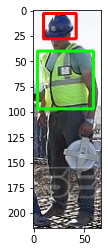

In [146]:
draw_examples("ppe_0917_2.jpg")

Image shape: (315, 169, 3)
Bbox0: ((10, 4), (108, 48))
Bbox1: ((6, 130), (154, 311))


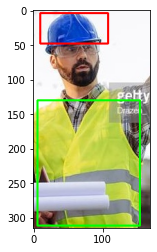

In [12]:
draw_examples("ppe_0977_1.jpg")

Image shape: (129, 32, 3)
['hardhat 0 0 0 13 9 29 20 0 0 0 0 0 0 0\n', 'highvizvest 0 0 0 4 27 28 78 0 0 0 0 0 0 0\n']
Bbox0: ((13, 9), (29, 20))
Bbox1: ((4, 27), (28, 78))


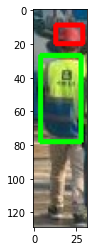

In [344]:
draw_examples("ppe_0751_4.jpg")

Below code was used for debugging purpose to identify if a label file had duplicate vest or helmet co-ordinates

In [207]:
# Find labels that have two hardhats or highvizvests for same person
# Move that to a different directory then analyze manually to correct the labels

duplicate_label_list = []
annotations_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/labels"
annotations_fps = glob.glob(os.path.join(annotations_dir, "*.txt"))

for annotation_fp in annotations_fps:
    with open(annotation_fp, "r") as fp:
        lines = fp.readlines()
        label_list = [line.strip().split(' ')[0] for line in lines]
    if label_list.count('hardhat') > 1 or label_list.count('highvizvest') > 1:
        duplicate_label_list.append(annotation_fp)

In [305]:
import subprocess
image_fp = '/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/images/'
label_fp_ = '/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/labels/'

move_imag_dir = '/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/duplicate_labelled_images/images/'
move_label_dir = '/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/duplicate_labelled_images/labels/'

for label_fp in duplicate_label_list[1:]:
    label = label_fp.split('/')[-1]
    image = label.replace('txt','jpg')
    print(image)
    print(label)
    subprocess.call(["mv", os.path.join(image_fp, image), move_imag_dir])
    subprocess.call(["mv", os.path.join(label_fp_, label), move_label_dir])
    

In [274]:
# Few images did not generate labels so saving those images in a directory to analyze later
# Possibly images with people with no harhat or vests

dataset_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels"

# Create a list of all images
image_dir = os.path.join(dataset_dir, "images")
image_fps = glob.glob(os.path.join(image_dir, "*.jpg"))

image_files_all = []
for image_fp in image_fps:
    file = image_fp.split('/')[-1]
    image_files_all.append(file)

# Create a list of images with labels
annotations_dir = os.path.join(dataset_dir, "labels")
annotations_fps = glob.glob(os.path.join(annotations_dir, "*.txt"))

image_files_with_labels = []
for annotations_fp in annotations_fps:
    annot_file = annotations_fp.split('/')[-1]
    image_name = annot_file.replace('txt','jpg')
    image_files_with_labels.append(image_name)

print(f'Images with labels: {len(image_files_with_labels)}')
print(f'Total number of Images: {len(image_files_all)}')


images_not_needed = []
images_needed = []
for file in image_files_all:
    if file in image_files_with_labels:
        images_needed.append(file)
    else:
        images_not_needed.append(file)

print(f'Images needed to move: {len(images_not_needed)}')


Images with labels: 3227
Total number of Images: 3784
Images needed to move: 557


In [294]:
move_image_to_dir = os.path.join(dataset_dir, "images_with_no_label_files")
for image in images_not_needed:
    move_image_from_dir = os.path.join(image_dir, image)
    subprocess.call(["mv", move_image_from_dir, move_image_to_dir])
    

mv: cannot stat '/home/jaydeep/pictor-ppe/data/CHV_dataset/approach-3/hardhat_highvizvest_dataset/cropped_person_images_labels/images/ppe_0911_1.jpg': No such file or directory


References:

- https://automaticaddison.com/how-to-apply-a-mask-to-an-image-using-opencv/ 

- https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

- https://github.com/zarar7576/YOLO_TO_KITTI 